# Sheet 2 - Simulation exercise (Gaussian mixture model - Gibbs sampling) 

In [1]:
using Distributions, StatsPlots, Plots, StatsBase
pyplot()

Plots.PyPlotBackend()

## Sample synthetic dataset from mixture model.

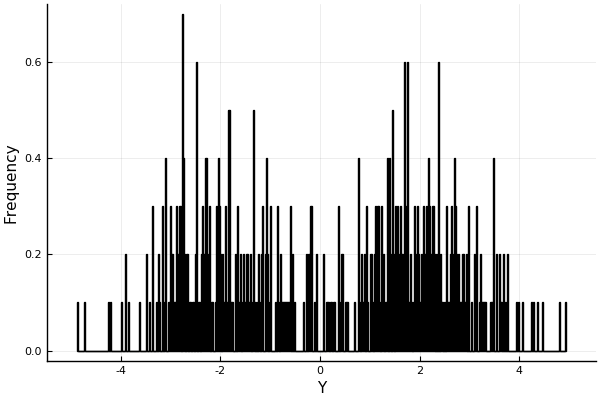

In [1387]:
mu0    = [-2,2]
sigma2= [1,1]
p0     = [0.5,0.5]
w = Weights(p0)
M = 500
X = zeros(M)
s = sample(1:2, w,M)
for i = 1:M
    j = s[i]
    X[i]+= rand(Normal(mu0[j],sigma2[j]))
end

p = histogram(X,xlabel="Y",ylabel="Frequency",normalize=true,legend=false,nbins=M)
# savefig(p,"./images/Ex6.png")

### Initial step:
* Sample from prior p      ~ Dirichlet
* Sample from prior μk     ~ N(m, tau^2)
* Sample from prior sig2_k ~ IG(alpha, beta)

### After that, sample from the full conditionals:
* Sample Z | p, mu, sig2 , Y ~ P(Z_i = k | p,y,mu,sig2) = p_k*pdf(Normal(mu,sig),y)
* Sample p1,...,pk | Z, mu, sig2, Y ~ Dirichlet (gamma1 + n1,...,gammak + nk)
* Sample sig2_1,...,sig2_k | Z, mu, p, Y $\sim
\text{Inverse Gamma}\left(
\alpha + \frac{n_k}{2}, \beta +
\frac{\sum_{i=1}^{n_k}(x_i - \mu_k)^2}{2}
\right)
$
* Sample mu_1, ... , mu_k | Z, sig2, p, Y$ \sim
N\left(
\frac{n_k \sigma_k ^{-2}\bar{x_k} + \tau^{-2}m}
{n_k\sigma^2_k}
, [n_k\sigma_k^{-2} + \tau^{-2}]^{-1}
\right)$

In [1388]:
y     = X
M = length(y)
k = 2
gamma, m, tau, alpha, beta = [1,1],0,100,0.01,0.01
steps = 10000
posterior = zeros(steps,k*3)

p   = rand(Dirichlet(gamma))
mu  = rand(Normal(m,sqrt(tau)),k)
sig = 1 ./ (rand(Distributions.Gamma(alpha, beta^-1),k))
# sig = rand(InverseGamma(alpha,beta^(-1)),k)


for s=1:steps
    z = zeros(M)
    for i = 1:M
        w1 = p[1] * pdf(Normal(mu[1],sqrt(sig[1])),y[i])
        w2 = p[2] * pdf(Normal(mu[2],sqrt(sig[2])),y[i])
        z[i] += sample(1:k, Weights([w1,w2]))
    end
    n1 = sum(z .== 1)
    n2 = sum(z .== 2)
    sum1 = sum(y[z .== 1])
    sum2 = sum(y[z .== 2])

    p  = rand(Dirichlet(gamma + [n1,n2]))

    m_p1   = (1/(1/tau + n1/sig[1])) * (m/tau + sum1/sig[1])
    m_p2   = (1/(1/tau + n2/sig[2])) * (m/tau + sum2/sig[2])
    tau_p1 = (1/tau + n1/sig[1])^(-1)
    tau_p2 = (1/tau + n2/sig[2])^(-1)

    mu[1] = rand(Normal(m_p1,sqrt(tau_p1)))
    mu[2] = rand(Normal(m_p2,sqrt(tau_p2)))

    sumsq1= sum((y[z .== 1] .- mu[1]).^2)
    sumsq2= sum((y[z .== 2] .- mu[2]).^2)

    alpha1= alpha + 0.5*n1
    alpha2= alpha + 0.5*n2
    beta1 = beta  + 0.5*sumsq1
    beta2 = beta  + 0.5*sumsq2
    sig[1]= 1/(rand(Distributions.Gamma(alpha1, beta1^-1)))
    sig[2]= 1/(rand(Distributions.Gamma(alpha2, beta2^-1)))

    posterior[s,:] = posterior[s,:] + vcat(p,mu,sig)
    
end

#### Post-processing
Let's order the results by making mu1>mu2 and p1>p2

In [1389]:
p1 = zeros(steps)
p2 = zeros(steps)
mu1 = zeros(steps)
mu2 = zeros(steps)
sig1 = zeros(steps)
sig2 = zeros(steps)
for i = 1:steps
    if posterior[i,1] >= posterior[i,2]
    else
    end
end

for i = 1:steps
    if posterior[i,3] >= posterior[i,4]
        mu1[i] = posterior[i,3]
        mu2[i] = posterior[i,4]
        p1[i] = posterior[i,1]
        p2[i] = posterior[i,2]
        sig1[i] = posterior[i,5]
        sig2[i] = posterior[i,6]
    else
        mu1[i] = posterior[i,4]
        mu2[i] = posterior[i,3]
        p1[i] = posterior[i,2]
        p2[i] = posterior[i,1]
        sig1[i] = posterior[i,6]
        sig2[i] = posterior[i,5]
    end
end



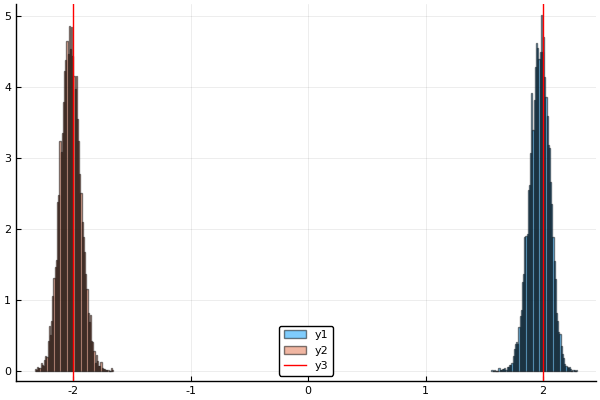

In [1390]:
histogram(mu1[1000:end],normalize=true,alpha=0.5)
histogram!(mu2[1000:end],normalize=true,alpha=0.5)
vline!(mu0,color="red")

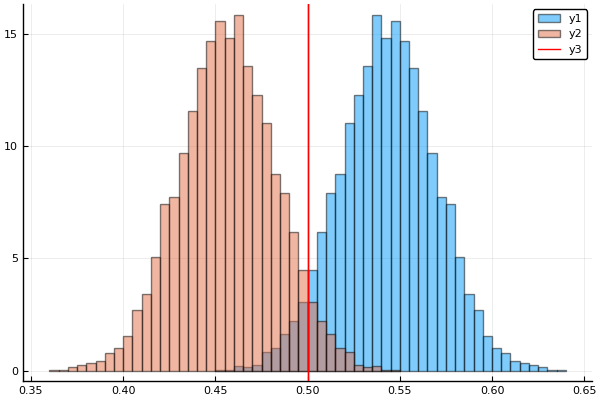

In [1391]:
histogram(p1[1000:end],normalize=true,alpha=0.5)
histogram!(p2[1000:end],normalize=true,alpha=0.5)
vline!(p0,color="red")

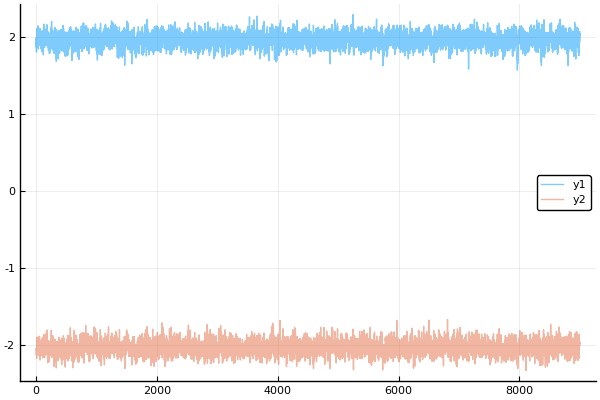

In [1392]:
plot(mu1[1000:end],normalize=true,alpha=0.5)
plot!(mu2[1000:end],normalize=true,alpha=0.5)

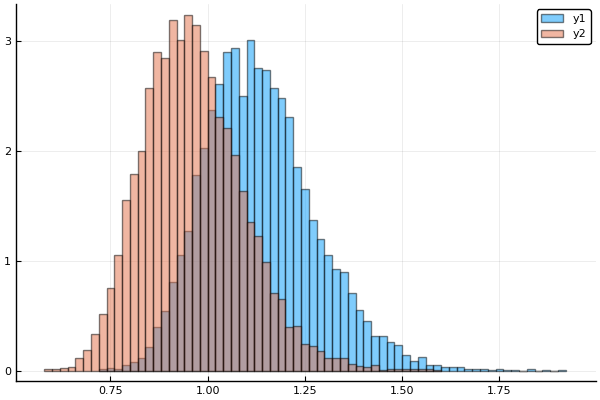

In [1393]:
histogram(sig1[1000:end],normalize=true,alpha=0.5)
histogram!(sig2[1000:end],normalize=true,alpha=0.5)

In [841]:

function SamplePosterior_Z(p,M,mu,sig,y)
    z = zeros(M)
    for n =1:M
        w = zeros(k)
        for i=1:k
            w[i] = p[i] * exp((-(y[n]-mu[i])^2)/(2*sig[i]))/(sqrt(2*3.14*sig[i]))
        end
#         println(w)
        z[n] = sample(1:k, Weights(w))
    end
    return z
end


function SamplePosterior_p(z, gamma)
    gamma_p = zeros(k)
    for i = 1:k
        n   = sum(z.==i)
#         println(n)
        gamma_p[i] = gamma[i] + n
    end
    p = rand(Dirichlet(gamma_p))
    return p
end

function SamplePosterior_sigma(z,mu,alpha,beta,y)
    sig = zeros(k)
    for i = 1:k
        n   = sum(z.==i)
        alpha_p = alpha + n/2
        beta_p  = beta + sum((y[z .== i].-mu[i]).^2)/2
        sig[i]  = 1/(rand(Gamma(alpha_p,beta_p)))
#         sig[i] = rand(InverseGamma(alpha_p,beta_p^(-1)))
    end
    return sig
end

function SamplePosterior_mu(z,m,tau,sig)
    mu = zeros(k)
    for i = 1:k
        n   = sum(z.==i)
        m_p = ( (sig[i]^(-1))*(sum(y[z .== i])) + (tau^(-1))*m ) / ( n*sig[i]^(-1) + (tau^(-1)))
        tau_p = 1/((n*sig[i]^(-1))+tau^(-2))
        mu[i]   = rand(Normal(m_p,sqrt(tau_p)))
    end
    return mu
end


function Gibbs_Sampler_Mixture(steps,y,k,gamma,m,tau,alpha,beta)
    #Initilialize by sampling from the priors
    p   = rand(Dirichlet(gamma))
    mu  = rand(Normal(m,tau),k)
    sig = rand(InverseGamma(alpha,beta^(-1)),k)
    
    # Start the updating
    posterior = zeros(steps,k*3)
    for i = 1:steps
        posterior[i,:] = posterior[i,:] + vcat(p,mu,sig)
        z = SamplePosterior_Z(p,M,mu,sig,y)
        p = SamplePosterior_p(z,gamma)
        mu  = SamplePosterior_mu(z,m,tau,sig)
        sig = SamplePosterior_sigma(z,mu,alpha,beta,y)
    end
    return posterior
end

steps = 10
y     = X
k = 2
# gamma, m, tau, alpha, beta = [1,1,1],0,1,3,3
gamma, m, tau, alpha, beta = [1,1],0,10,0.1,0.1
simulation = Gibbs_Sampler_Mixture(steps,y,k,gamma,m,tau,alpha,beta);

simulation

10×6 Array{Float64,2}:
 0.783682   0.216318      2.51038    …  2526.91         3075.23       
 0.764415   0.235585    -29.9214           7.13518e-7      9.3693e-6  
 0.987477   0.0125229    -0.44113          0.000218065     1.43189e7  
 0.0138816  0.986118     -0.459955        21.1784          8.50892e-9 
 0.957541   0.0424586    -0.449858         0.000336931     3.91565e13 
 0.0448316  0.955168     -0.429123   …     3.12599         8.8174e-8  
 0.996579   0.00342072   -0.471398         0.000231141  4993.16       
 0.0421153  0.957885     -0.460206        37.331           2.45624e-6 
 0.99698    0.00301964    0.101666         0.000241223   161.236      
 0.0552323  0.944768      0.0507418        1.66415         0.000223905

In [491]:
simulation
pdf(Normal(simulation[10,3],sqrt(simulation[10,5])),y[1])
# plot(simulation[:,3])
# plot!(simulation[:,4])
# histogram(y,nbins=100)


3.929491796962375e-8

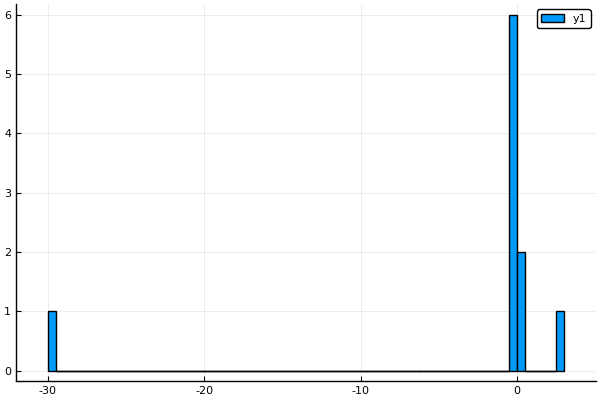

In [843]:
histogram(simulation[:,3])
# histogram!(simulation[:,5])
# histogram!(simulation[:,6])
# matr= zeros(1,9)
# matr[1,:] + vcat(rand(3),rand(3),rand(3))

In [205]:
k = 3
gamma, m, tau, alpha, beta = [1,1,1],0,1,3,1
# function Priors(gamma,m,tau,alpha,beta)
#     rand(Dirichlet())
# end

function Posterior_p(Z,mu,sig2,Y)
    
end

Posterior_p (generic function with 1 method)

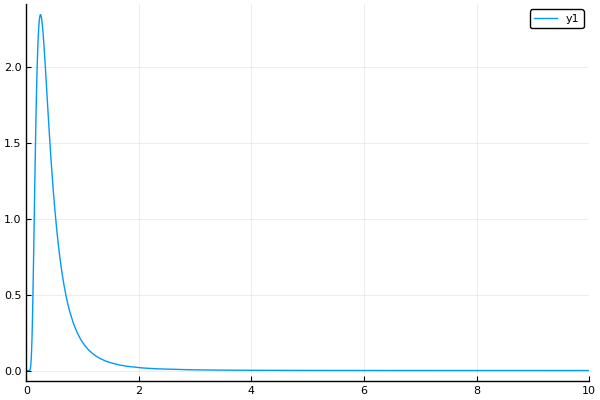

In [129]:
plot(InverseGamma(alpha,beta^-1),xlims=(0,10))